# Quick start with keras for Star Craft classification  
The objective of this guide is to show how to train a model from disk using keras. This is useful if your training or testing set is numerous and you just can not have a numpy array with all the values.  
  
This guide will show you how to use a multilayer perceptron for a feature you extract from images. The data set has the Star craft units for Protoss, Terran And Zerg that I found here **[1]**.  In another guide I will show how to use Convolutional Neural Networks for the same purposes.
  
* [1]http://starcraft.wikia.com/wiki/List_of_StarCraft_II_units  


In [9]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

show the files in the current location

In [2]:
#First get the data
!ls

${f}  keras_class.ipynb  notes	SC2Units  sc2_units_files  sc2_units.html


The folder **SC2Units** has the images. We use os to list the content of it.

In [3]:
image_dir = 'SC2Units/'

images = os.listdir(image_dir)
print(images)    

['Banshee_SC2_Icon1.jpg', 'Icon_Zerg_Drone.jpg', 'Icon_Zerg_Hydralisk.jpg', 'Icon_Zerg_Baneling_Nest.jpg', 'Icon_Protoss_High_Templar.jpg', 'CommandCenter_SC2_Icon1.jpg', 'Viking_SC2_Icon1.jpg', 'Icon_Zerg_Overlord.jpg', 'Icon_Protoss_Cybernetics_Core.jpg', 'Icon_Protoss_Sentry.jpg', 'Icon_Zerg_Queen.jpg', 'Icon_Protoss_Templar_Archives.jpg', 'Icon_Zerg_Nydus_Network.jpg', 'Icon_Protoss_Phoenix.jpg', 'Icon_Zerg_Hatchery.jpg', 'Icon_Zerg_Creep_Tumor.jpg', 'Icon_Zerg_Roach_Warren.jpg', 'Icon_Zerg_Nydus_Worm.jpg', 'Hellbat_SC2-HotS_Icon1.jpg', 'MULE_SC2_Icon1.jpg', 'Hellion_SC2_Icon1.jpg', 'Liberator_SC2-LotV_Icon1.jpg', 'Armory_SC2_Icon1.jpg', 'Icon_Zerg_Spire.jpg', 'Icon_Zerg_Corruptor.jpg', 'Icon_Zerg_Lair.jpg', 'Raven_SC2_Icon1.jpg', 'Reaper_SC2_Icon1.jpg', 'Cyclone_SC2-LotV_Icon1.jpg', 'Icon_Protoss_Oracle.jpg', 'Icon_Zerg_Viper.jpg', 'Icon_Protoss_Photon_Cannon.jpg', 'Icon_Protoss_Dark_Shrine.jpg', 'SupplyDepot_SC2_Icon1.jpg', 'Icon_Protoss_Mothership.jpg', 'Icon_Protoss_Robotics_Fa

Now we define a Dataframe that will have in one column the location to the images and in another a vector, **hot encoding**, for the three races.  
Later, we shuffle the dataframe and split it into training and testing.  

In [4]:
classes = {'Zerg':np.array([[1,0,0]]),
            'Protoss':np.array([[0,1,0]]),
           'Terran':np.array([[0,0,1]]),
            }
to_df = []
for image in images:
    if ".jpg" in image:
        fullname = image_dir+image
        unit_class = 'Terran'
        if 'Zerg' in image:
            unit_class='Zerg'
        elif 'Protoss' in image:
            unit_class='Protoss'
        to_df.append({'filename':fullname,'target':classes[unit_class]})
sc2_df = pd.DataFrame(to_df)

print("first 10 lines of Dataframe \n",sc2_df.head(10))
print("Shape of target array:",sc2_df['target'][0].shape)

#Shuffle the DataFrame, frac=1, means to take a sample of a fraction size of 1, so 100%
# We reset the index to have a "new" dataframe without a record of the previous order.
sc_df = sc2_df.sample(frac=1).reset_index()

#Split into training and testing set
training_fraction = 0.8
rows = sc_df.shape[0]
train_rows = int(rows*training_fraction)
test_rows = rows - train_rows

train_df = sc_df.head(train_rows)
test_df = sc_df.tail(test_rows)


print(train_df.shape,test_df.shape)
print("Training head 2:\n",train_df.head(2))
print("Testing head 2:\n",test_df.head(2))

first 10 lines of Dataframe 
                                      filename       target
0              SC2Units/Banshee_SC2_Icon1.jpg  [[0, 0, 1]]
1                SC2Units/Icon_Zerg_Drone.jpg  [[1, 0, 0]]
2            SC2Units/Icon_Zerg_Hydralisk.jpg  [[1, 0, 0]]
3        SC2Units/Icon_Zerg_Baneling_Nest.jpg  [[1, 0, 0]]
4      SC2Units/Icon_Protoss_High_Templar.jpg  [[0, 1, 0]]
5        SC2Units/CommandCenter_SC2_Icon1.jpg  [[0, 0, 1]]
6               SC2Units/Viking_SC2_Icon1.jpg  [[0, 0, 1]]
7             SC2Units/Icon_Zerg_Overlord.jpg  [[1, 0, 0]]
8  SC2Units/Icon_Protoss_Cybernetics_Core.jpg  [[0, 1, 0]]
9            SC2Units/Icon_Protoss_Sentry.jpg  [[0, 1, 0]]
Shape of target array: (1, 3)
(88, 3) (22, 3)
Training head 2:
    index                           filename       target
0      9   SC2Units/Icon_Protoss_Sentry.jpg  [[0, 1, 0]]
1     46  SC2Units/Icon_Protoss_Tempest.jpg  [[0, 1, 0]]
Testing head 2:
     index                              filename       target
88     7

We create a function to load an image from a file location and in addition we resize it to a shape **(64,64)**.

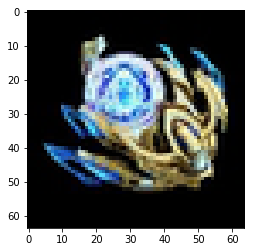

In [5]:
def image_file_to_np(ifile,resize=(64,64)):
    pil_img = Image.open(ifile)
    pil_img = pil_img.resize(resize,Image.ANTIALIAS)
    np_img = np.asarray(pil_img)
    pil_img.close()
    return np_img.copy()

test_img = train_df['filename'][0]
test_img = image_file_to_np(test_img)
plt.imshow(test_img)
plt.show()

Next, we define a function that will use the numpy image and extract some features. In this case a histogram for the three channels, and will concatenate one after the other. The number of bars is represented by the variable **bins**.

(1, 30)


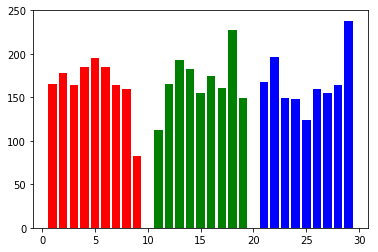

In [6]:
def np_img_to_hist(inp,bins=10):
    return np.hstack([ np.histogram(inp[:,:,x],bins=bins)[0] for x in range(3)]).reshape(1,bins*3)

def plot_hist(i_np_hist):
    x_bins = np.arange(0,i_np_hist.shape[1])
    for x,h in zip(x_bins,i_np_hist.flatten()):
        if x%10!=0:#Not counting the black
            if x<10:
                c='red'
            elif x<20:
                c='green'
            else:
                c='blue'
            plt.bar(x,h,color=c)
    plt.show()

test_hist = np_img_to_hist(test_img,bins=10)
print(test_hist.shape)

#Plot the histogram of values
plot_hist(test_hist)

## Create a function to create batches from disk  
We need to load the content according to the mini-batch size, so the previous functions of loading a numpy array from disk and extracting a histogram must be called only for a batch. 

In [7]:
def batch_hist_from_df(idf,x_col='filename',y_col='target',batch_size=4,offset=4,resize=(64,64),bins=10):
    start_index = offset
    rows = idf.shape[0]
    if start_index >= rows:
        start_index = start_index%rows
    end_index = start_index + batch_size
    
    if end_index>rows:
        end_index = rows
    
    tdf = idf.iloc[start_index:end_index]
    _y = np.vstack(tdf[y_col])
    
    arrays = list(map(lambda x: image_file_to_np(x,resize=resize),tdf[x_col]))
    _x = np.vstack(list(map(lambda x: np_img_to_hist(x,bins=bins),arrays)))
    return _x.copy(),_y.copy()
        

xb,yb = batch_hist_from_df(idf=train_df,x_col='filename',y_col='target',
                           batch_size=4,offset=4,resize=(64,64),bins=10)

print(xb.shape,yb.shape)

(4, 30) (4, 3)


### The keras model
In the keras website we find this quickstart to build a model:  

from keras.models import Sequential
model = Sequential()
from keras.layers import Dense
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True))
model.train_on_batch(x_batch, y_batch)
#Evaluate
loss_and_metrics = model.evaluate(x_test, y_test)
#Prediction
classes = model.predict(x_test)  

### Changing our model  
Here we have defined how many bins we want for the histogram, number of iterations (epochs), learning rate, batch-size, the resizing shape for each image.  
We use batch normalization after each fully connected layer for a better performance.

In [27]:
bins_per_channel = 128
input_dims = bins_per_channel*3 #RGB
output_classes = 3 #Terran, Protoss, Zerg
iterations = 120
learning_rate=1e-4
batch_size=4
resize_shape = (64,64)
x_col='filename'
y_col='target'

#Model

model = Sequential()

model.add(Dense(units=16, activation='relu', input_dim=input_dims))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=output_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True))

# Iterations

rows = train_df.shape[0]
batches = int(np.ceil(rows/batch_size))

for iterx in range(iterations):
    for batch in range(batches):
        offset = batch*batch_size
        xb,yb = batch_hist_from_df(idf=train_df,x_col=x_col,y_col=y_col,
                           batch_size=batch_size,offset=offset,
                            resize=resize_shape,bins=bins_per_channel)
        loss = model.train_on_batch(xb, yb)
        print("Iter",iterx,"/",iterations,"Batch",batch,"/",batches,"Loss:",loss)


Iter 0 Batch 0 / 22 Loss: 1.6536396
Iter 0 Batch 1 / 22 Loss: 1.0313554
Iter 0 Batch 2 / 22 Loss: 1.0657228
Iter 0 Batch 3 / 22 Loss: 1.0714729
Iter 0 Batch 4 / 22 Loss: 1.1490614
Iter 0 Batch 5 / 22 Loss: 0.4619735
Iter 0 Batch 6 / 22 Loss: 1.5612675
Iter 0 Batch 7 / 22 Loss: 1.2878578
Iter 0 Batch 8 / 22 Loss: 1.6079942
Iter 0 Batch 9 / 22 Loss: 0.5196297
Iter 0 Batch 10 / 22 Loss: 2.4733205
Iter 0 Batch 11 / 22 Loss: 1.3874974
Iter 0 Batch 12 / 22 Loss: 1.5880681
Iter 0 Batch 13 / 22 Loss: 1.515432
Iter 0 Batch 14 / 22 Loss: 1.9616457
Iter 0 Batch 15 / 22 Loss: 1.6095573
Iter 0 Batch 16 / 22 Loss: 1.1904781
Iter 0 Batch 17 / 22 Loss: 1.7724915
Iter 0 Batch 18 / 22 Loss: 2.0570128
Iter 0 Batch 19 / 22 Loss: 0.9210616
Iter 0 Batch 20 / 22 Loss: 1.9735522
Iter 0 Batch 21 / 22 Loss: 1.9311455
Iter 1 Batch 0 / 22 Loss: 1.5936828
Iter 1 Batch 1 / 22 Loss: 1.1557336
Iter 1 Batch 2 / 22 Loss: 1.4624382
Iter 1 Batch 3 / 22 Loss: 0.75132537
Iter 1 Batch 4 / 22 Loss: 1.6848018
Iter 1 Batch 5 /

### Test our model in the testing set  
Now, we define our batch testing using the testing set. Since the **predict** or **evaluate ** functions of the model keras doesn't have the metrics parameter, we calculate the accuracy manually.

In [43]:

#Evaluate
#loss_and_metrics = model.evaluate(x_test, y_test)
test_rows = test_df.shape[0]
tbatches = int(np.ceil(test_rows/batch_size))
general_accuracy = []

for batch in range(tbatches):
    offset = batch*batch_size
    xb,yb = batch_hist_from_df(idf=test_df,x_col=x_col,y_col=y_col,
                           batch_size=batch_size,offset=offset,
                            resize=resize_shape,bins=bins_per_channel)
    
    classes = model.predict(xb)
    loss = model.evaluate(xb, yb,verbose=0)
    
    class_pred = np.argmax(classes,1)
    print("Batch",batch,"/",tbatches,"Loss:",loss)
    ground_truth = np.argmax(yb,1)
    
    accuracy = sum(np.equal(class_pred,ground_truth))/batch_size
    general_accuracy.append(accuracy)    

print("Total accuracy",np.mean(general_accuracy))

Batch 0 / 6 Loss: 0.9565176963806152
Batch 1 / 6 Loss: 1.0996533632278442
Batch 2 / 6 Loss: 1.2299405336380005
Batch 3 / 6 Loss: 1.0088927745819092
Batch 4 / 6 Loss: 0.685764729976654
Batch 5 / 6 Loss: 0.884490966796875
Total accuracy 0.4583333333333333
